**[기계학습 중간고사 대체과제]**

목표 : Python과 scikit-learn을 사용하여 클러스터링 분석을 수행하여 데이터에 숨겨진 그룹을 발견합니다.

* 문제정의 : 클러스터링을 이용한 장애인의 서울지하철 승강장 접근성 수준을 분석합니다. 서울지하철 1~9호선의 역사 내의 엘리베이터와 휠체어리프트의 수를 기반으로 클러스터링을 수행하여 장애인의 지하철 접근성이 높은역과 낮은 역을 식별하는 것입니다.

* 데이터선택 : https://www.data.go.kr/data/15119423/fileData.do 의 서울시 지하철 역사 노약자 장애인 편의시설 현황.csv을 활용했습니다.



---



# 0. 실행을 위한 환경을 구축합니다.

In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn

# 1. 모듈들을 import 합니다.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 2. 공공데이터 포털에서 다운로드 받은 서울시 지하철 역사 노약자 장애인 편의시설 현황을 로드하여 데이터를 확인합니다.

*   호선, 역명, 엘리베이터, 에스컬레이터, 휠체어리프트, 수평자동보도의 개수가 나와있으며, 총 286개의 역의 편의시설 현황이 나와있습니다.

In [3]:
# 데이터 로드
file_url = '/content/Status of convenience facilities.csv'
try:
    data = pd.read_csv(file_url, encoding='utf-8')
except UnicodeDecodeError:
    data = pd.read_csv(file_url, encoding='cp949')

print(data.head())


    호선       역명  엘리베이터(E/V)  에스컬레이터(E/S)  휠체어리프트(W/L)  수평자동보도(M/W)
0  1호선   서울역(1)           4            5            1            0
1  1호선    시청(1)           3            3            0            0
2  1호선       종각           4            2            0            0
3  1호선  종로3가(1)           3            4            0            0
4  1호선     종로5가           3            0            0            0


In [4]:
data

,호선,역명,엘리베이터(E/V),에스컬레이터(E/S),휠체어리프트(W/L),수평자동보도(M/W)
0,1호선,서울역(1),4,5,1,0
1,1호선,시청(1),3,3,0,0
2,1호선,종각,4,2,0,0
3,1호선,종로3가(1),3,4,0,0
4,1호선,종로5가,3,0,0,0
...,...,...,...,...,...,...
281,9호선(3단계),송파나루역,5,6,0,0
282,9호선(3단계),한성백제역,3,12,0,0
283,9호선(3단계),올림픽공원역,3,14,0,0
284,9호선(3단계),둔촌오륜역,3,8,0,0


# 3. 변수선택을 위해 필요한 데이터를 전처리하고 저장합니다.

In [5]:
file_path = '/content/Status of convenience facilities.csv'

data = pd.read_csv(file_path, encoding='cp949')

data.columns = ['호선', '역명', '엘리베이터(E/V)', '에스컬레이터(E/S)', '휠체어리프트(W/L)', '수평자동보도(M/W)']

data = data.dropna(how='any')

cleaned_data = data[['역명', '엘리베이터(E/V)', '휠체어리프트(W/L)']]

cleaned_data.reset_index(drop=True, inplace=True)

pd.set_option('display.max_rows', 10)

cleaned_data



,역명,엘리베이터(E/V),휠체어리프트(W/L)
0,서울역(1),4,1
1,시청(1),3,0
2,종각,4,0
3,종로3가(1),3,0
4,종로5가,3,0
...,...,...,...
281,송파나루역,5,0
282,한성백제역,3,0
283,올림픽공원역,3,0
284,둔촌오륜역,3,0


In [ ]:
save_path = '/content/cleaned_status_of_convenience_facilities.csv'
cleaned_data.to_csv(save_path, index=False, encoding='utf-8-sig')

# 4. 그래프를 통해 데이터 분포를 확인합니다.


*   따로 뽑은 엘리베이터(E/V)와 휠체어리프트(W/L) 칼럼을 이용하여 그래프를 통해 확인합니다.


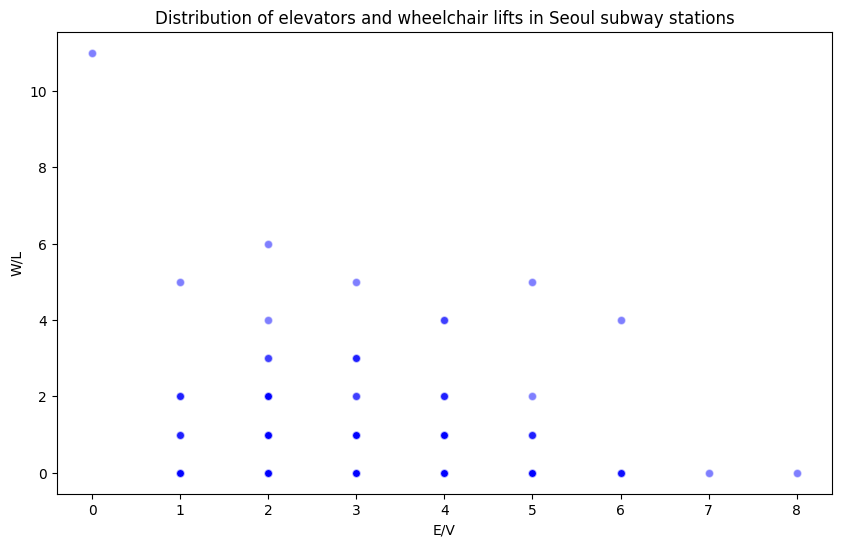

In [6]:
file_path = '/content/cleaned_status_of_convenience_facilities.csv'

try:
    data = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    data = pd.read_csv(file_path, encoding='cp949')

data['엘리베이터(E/V)'] = pd.to_numeric(data['엘리베이터(E/V)'], errors='coerce').fillna(0).astype(int)
data['휠체어리프트(W/L)'] = pd.to_numeric(data['휠체어리프트(W/L)'], errors='coerce').fillna(0).astype(int)

data.reset_index(drop=True, inplace=True)

plt.figure(figsize=(10, 6))
plt.scatter(data['엘리베이터(E/V)'], data['휠체어리프트(W/L)'], alpha=0.5, c='blue', edgecolors='w')
plt.title('Distribution of elevators and wheelchair lifts in Seoul subway stations')
plt.xlabel('E/V')
plt.ylabel('W/L')
plt.show()


# 5. K값 정하기
* 몇개의 군집으로 나눌지 정하기 위해 엘보우 방법을 이용하여 K값을 선정합니다.

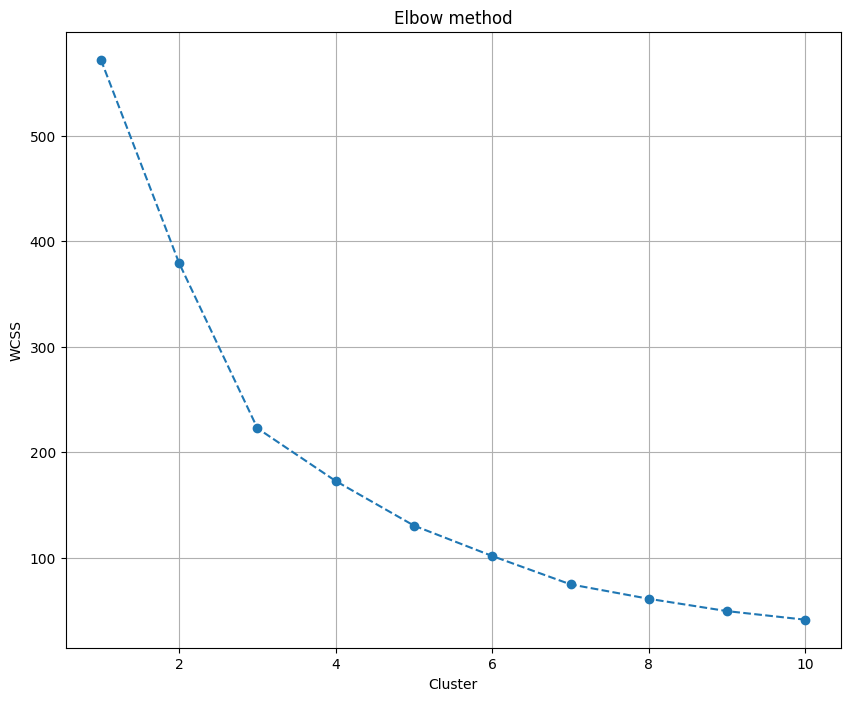

In [7]:
data = pd.read_csv('/content/cleaned_status_of_convenience_facilities.csv')

X = data[['엘리베이터(E/V)', '휠체어리프트(W/L)']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow method')
plt.grid(True)
plt.xlabel('Cluster')
plt.ylabel('WCSS')
plt.show()



# 6. 기존 데이터 프레임에 칼럼을 추가합니다.
* 4개의 군집으로 나눌 것으로 정하고, 데이터 프레임에 cluster_label 을 만들어 데이터프레임 컬럼에 추가했습니다.

In [8]:
X = data[['엘리베이터(E/V)', '휠체어리프트(W/L)']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=42)
kmeans.fit(X_scaled)

data['cluster_label'] = kmeans.labels_

print(data.head())


        역명  엘리베이터(E/V)  휠체어리프트(W/L)  cluster_label
0   서울역(1)           4            1              1
1    시청(1)           3            0              0
2       종각           4            0              1
3  종로3가(1)           3            0              0
4     종로5가           3            0              0


# 7. 클러스터링 시각화

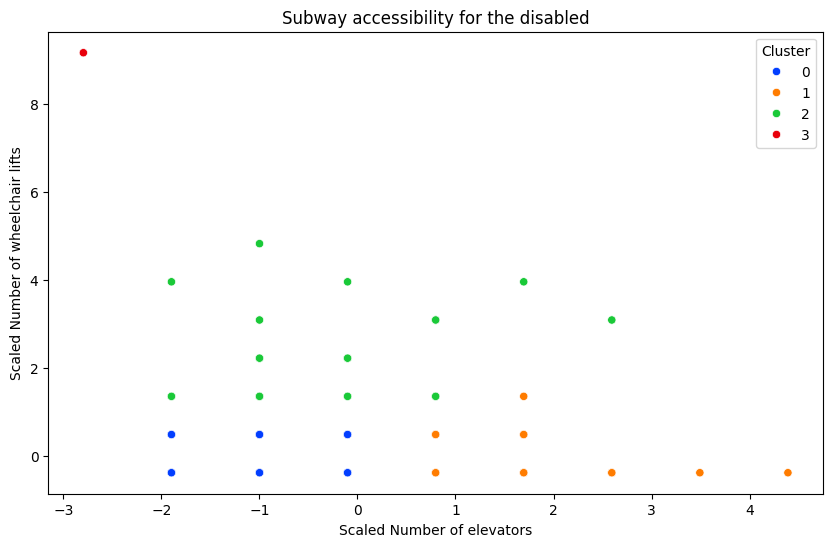

In [9]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)

data['cluster_label'] = kmeans.labels_

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=data['cluster_label'], palette='bright')
plt.title('Subway accessibility for the disabled')
plt.xlabel('Scaled Number of elevators')
plt.ylabel('Scaled Number of wheelchair lifts')
plt.legend(title='Cluster')
plt.show()

# 8. 실루엣 점수 및 평가

In [10]:
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
print(f"클러스터링의 실루엣 점수는 {silhouette_avg:.2f} 입니다.")

클러스터링의 실루엣 점수는 0.58 입니다.


In [11]:
data[data['cluster_label']==2]

,역명,엘리베이터(E/V),휠체어리프트(W/L),cluster_label
7,신설동(1),5,5,2
9,청량리(1),2,2,2
21,용답,2,2,2
24,신설동(2),2,6,2
94,상계,1,2,2
...,...,...,...,...
240,이수(7),3,3,2
250,가산디지털단지(7),4,4,2
254,온수(7),3,5,2
259,잠실(8),3,3,2


In [12]:
data[data['cluster_label']==1]

,역명,엘리베이터(E/V),휠체어리프트(W/L),cluster_label
0,서울역(1),4,1,1
2,종각,4,0,1
6,동묘앞(1),7,0,1
11,을지로입구,4,0,1
19,뚝섬,4,0,1
...,...,...,...,...
278,삼전역,4,0,1
279,석촌고분역,5,0,1
280,석촌역,5,0,1
281,송파나루역,5,0,1


In [13]:
data[data['cluster_label']==0]

,역명,엘리베이터(E/V),휠체어리프트(W/L),cluster_label
1,시청(1),3,0,0
3,종로3가(1),3,0,0
4,종로5가,3,0,0
5,동대문(1),3,0,0
8,제기동,3,0,0
...,...,...,...,...
270,신흥,2,0,0
271,수진,3,0,0
282,한성백제역,3,0,0
283,올림픽공원역,3,0,0


In [14]:
data[data['cluster_label']==3]

,역명,엘리베이터(E/V),휠체어리프트(W/L),cluster_label
249,남구로,0,11,3
